In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv("/Users/EthanMcElhone/Downloads/data-1.csv") 

In [3]:
land_mapping = {
    'valley floor / meadow': 0,
    'alpine meadow': 1,
    'alpine tundra': 2,
    'veg-scree mix': 3,
    'bare rock': 4,
    'scree / sunlit rock': 5,
    'dark rock': 6,
    'snow / ice': 7
}

df["land_type"] = df["land_type"].map(land_mapping)

In [4]:
Y = df["land_type"]

X = df.drop(columns = ["land_type", "rgb_hex", "overlay_hex"]) 

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size = 0.2, random_state = 42, stratify = Y)

In [5]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

Y_true_all, Y_pred_all, Y_prob_all = [], [], []

gbdt = GradientBoostingClassifier(n_estimators = 100,
                                  learning_rate = 0.15,
                                  max_depth = 2,
                                  subsample = 0.7,
                                  max_features = "sqrt",
                                  random_state = 42)

for train, value in skf.split(X_train, Y_train):
    Xtr, Xva = X_train.iloc[train], X_train.iloc[value]
    Ytr, Yva = Y_train.iloc[train], Y_train.iloc[value]
    
    gbdt.fit(Xtr, Ytr)
    Y_pred = gbdt.predict(Xva)
    Y_prob = gbdt.predict_proba(Xva)
    
    Y_true_all.append(Yva)
    Y_pred_all.append(Y_pred)
    Y_prob_all.append(Y_prob)

Y_train_cv_true = np.concatenate(Y_true_all)
Y_train_cv_pred = np.concatenate(Y_pred_all)
Y_train_cv_prob = np.vstack(Y_prob_all)

In [6]:
Y_cv = pd.DataFrame({"True Training CV": Y_train_cv_true,
                     "Predicted Training CV": Y_train_cv_pred})

Y_cv

,True Training CV,Predicted Training CV
0,2,2
1,1,1
2,4,4
3,0,0
4,6,6
...,...,...
172478,3,3
172479,3,3
172480,2,2
172481,3,3


In [7]:
Y_test_raw = pd.DataFrame(Y_test)
Y_test_raw = Y_test_raw.rename(columns={"land_type": "True Test"})
Y_test_raw["Predicted Test"] = gbdt.predict(X_test)

Y_test_raw

,True Test,Predicted Test
19906,2,2
124630,2,2
160459,3,3
123665,0,0
120034,5,5
...,...,...
121799,3,3
49550,2,2
67010,2,2
73533,0,0


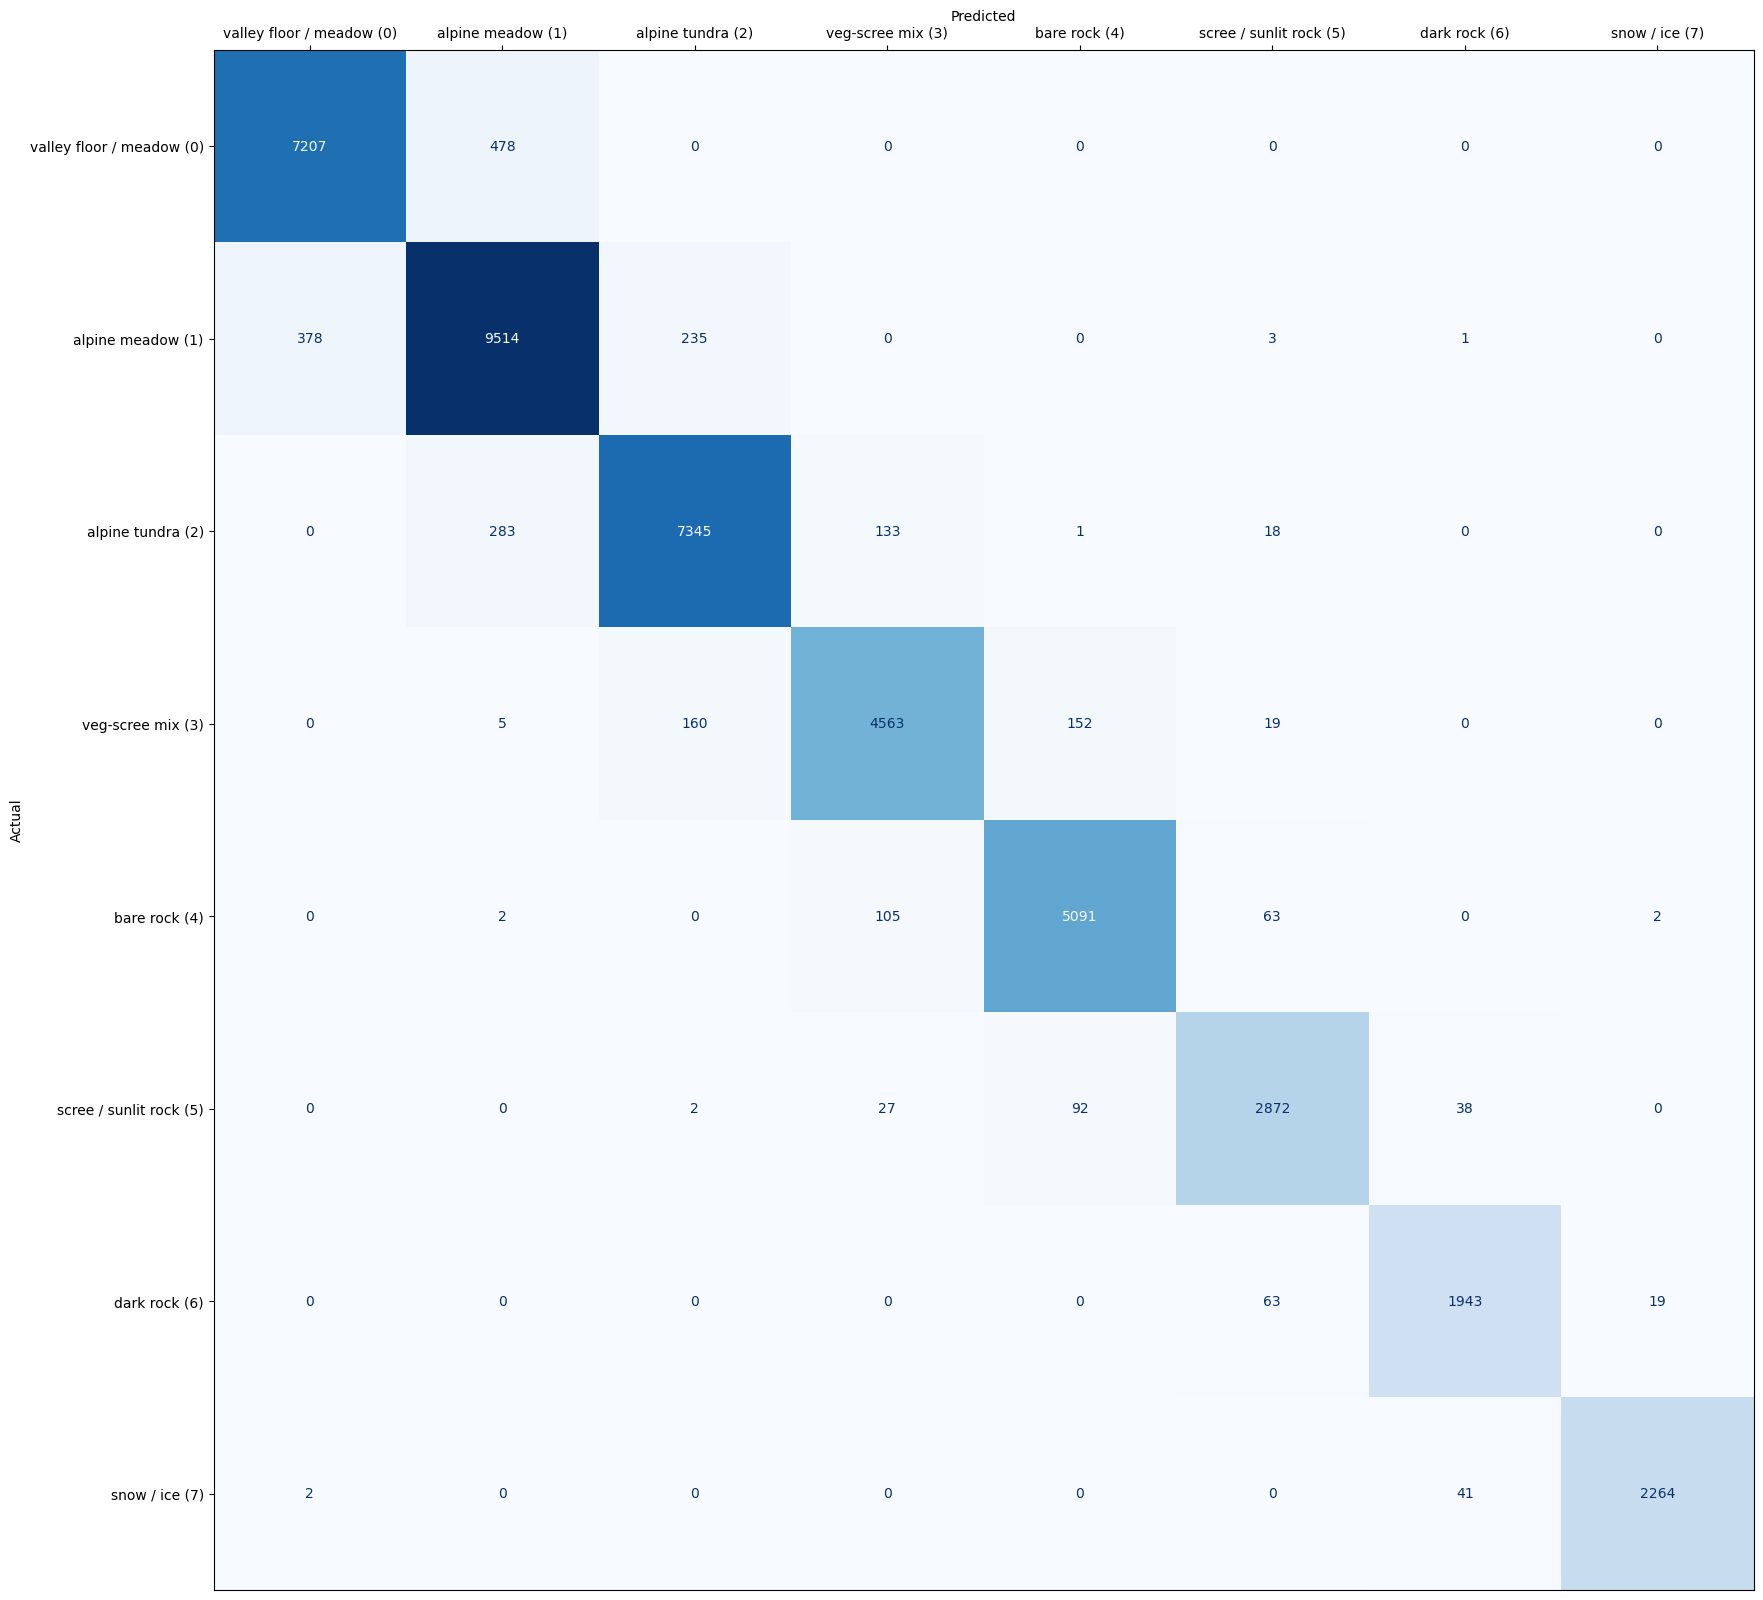

In [8]:
land_type = ["valley floor / meadow (0)", "alpine meadow (1)", "alpine tundra (2)", "veg-scree mix (3)", 
             "bare rock (4)", "scree / sunlit rock (5)", "dark rock (6)", "snow / ice (7)"]

fig, ax = plt.subplots(figsize = (30, 20))

Confusion_Matrix = ConfusionMatrixDisplay.from_predictions(y_true = Y_test_raw["True Test"],
                                                           y_pred = Y_test_raw["Predicted Test"],
                                                           labels = [0,1,2,3,4,5,6,7],
                                                           display_labels = land_type,
                                                           colorbar = False,
                                                           cmap = "Blues",
                                                           ax = ax)

plt.xlabel("Predicted")
plt.ylabel("Actual")
ax = Confusion_Matrix.ax_
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")
plt.show()

In [9]:
Y_true = Y_test_raw["True Test"].values
Y_pred = Y_test_raw["Predicted Test"].values
Y_prob = gbdt.predict_proba(X_test)

balanced_accuracies = []
f1_scores = []
aucs = []

for k in range(8):
    Y_true_k = (Y_true == k).astype(int)
    Y_pred_k = (Y_pred == k).astype(int)
    Y_prob_k = Y_prob[:, k]

    balanced_accuracies.append(balanced_accuracy_score(Y_true_k, Y_pred_k))
    f1_scores.append(f1_score(Y_true_k, Y_pred_k))
    aucs.append(roc_auc_score(Y_true_k, Y_prob_k))

accuracy = accuracy_score(Y_true, Y_pred)
avg_balanced_accuracy = np.mean(balanced_accuracies)
avg_f1 = np.mean(f1_scores)
avg_auc = np.mean(aucs)

results_df = pd.DataFrame({"Accuracy": [round(accuracy, 3)],
                           "Average Balanced Accuracy": [round(avg_balanced_accuracy, 3)],
                           "Average F1 Score": [round(avg_f1, 3)],
                           "Average AUC": [round(avg_auc, 3)]},
                           index = ["GBDT (raw)"])

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components = 10, random_state = 42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [11]:
Y_true_all_pca, Y_pred_all_pca, Y_prob_all_pca = [], [], []

for train, value in skf.split(X_train_pca, Y_train):
    Xtr_pca, Xva_pca = X_train_pca[train], X_train_pca[value]
    Ytr, Yva = Y_train.iloc[train], Y_train.iloc[value]

    gbdt.fit(Xtr_pca, Ytr)
    Y_pred_pca = gbdt.predict(Xva_pca)
    Y_prob_pca = gbdt.predict_proba(Xva_pca)

    Y_true_all_pca.append(Yva)
    Y_pred_all_pca.append(Y_pred_pca)
    Y_prob_all_pca.append(Y_prob_pca)

Y_train_cv_true_pca = np.concatenate(Y_true_all_pca)
Y_train_cv_pred_pca = np.concatenate(Y_pred_all_pca)
Y_train_cv_prob_pca = np.vstack(Y_prob_all_pca)

In [12]:
Y_cv_pca = pd.DataFrame({"True Training CV (PCA10)": Y_train_cv_true_pca,
                         "Predicted Training CV (PCA10)": Y_train_cv_pred_pca})

Y_cv_pca

,True Training CV (PCA10),Predicted Training CV (PCA10)
0,2,3
1,1,1
2,4,4
3,0,0
4,6,6
...,...,...
172478,3,3
172479,3,3
172480,2,2
172481,3,3


In [13]:
Y_test_pca = pd.DataFrame(Y_test)
Y_test_pca = Y_test_pca.rename(columns={"land_type": "True Test (PCA10)"})
Y_test_pca["Predicted Test (PCA10)"] = gbdt.predict(X_test_pca)

Y_test_pca

,True Test (PCA10),Predicted Test (PCA10)
19906,2,2
124630,2,2
160459,3,3
123665,0,0
120034,5,5
...,...,...
121799,3,3
49550,2,2
67010,2,2
73533,0,0


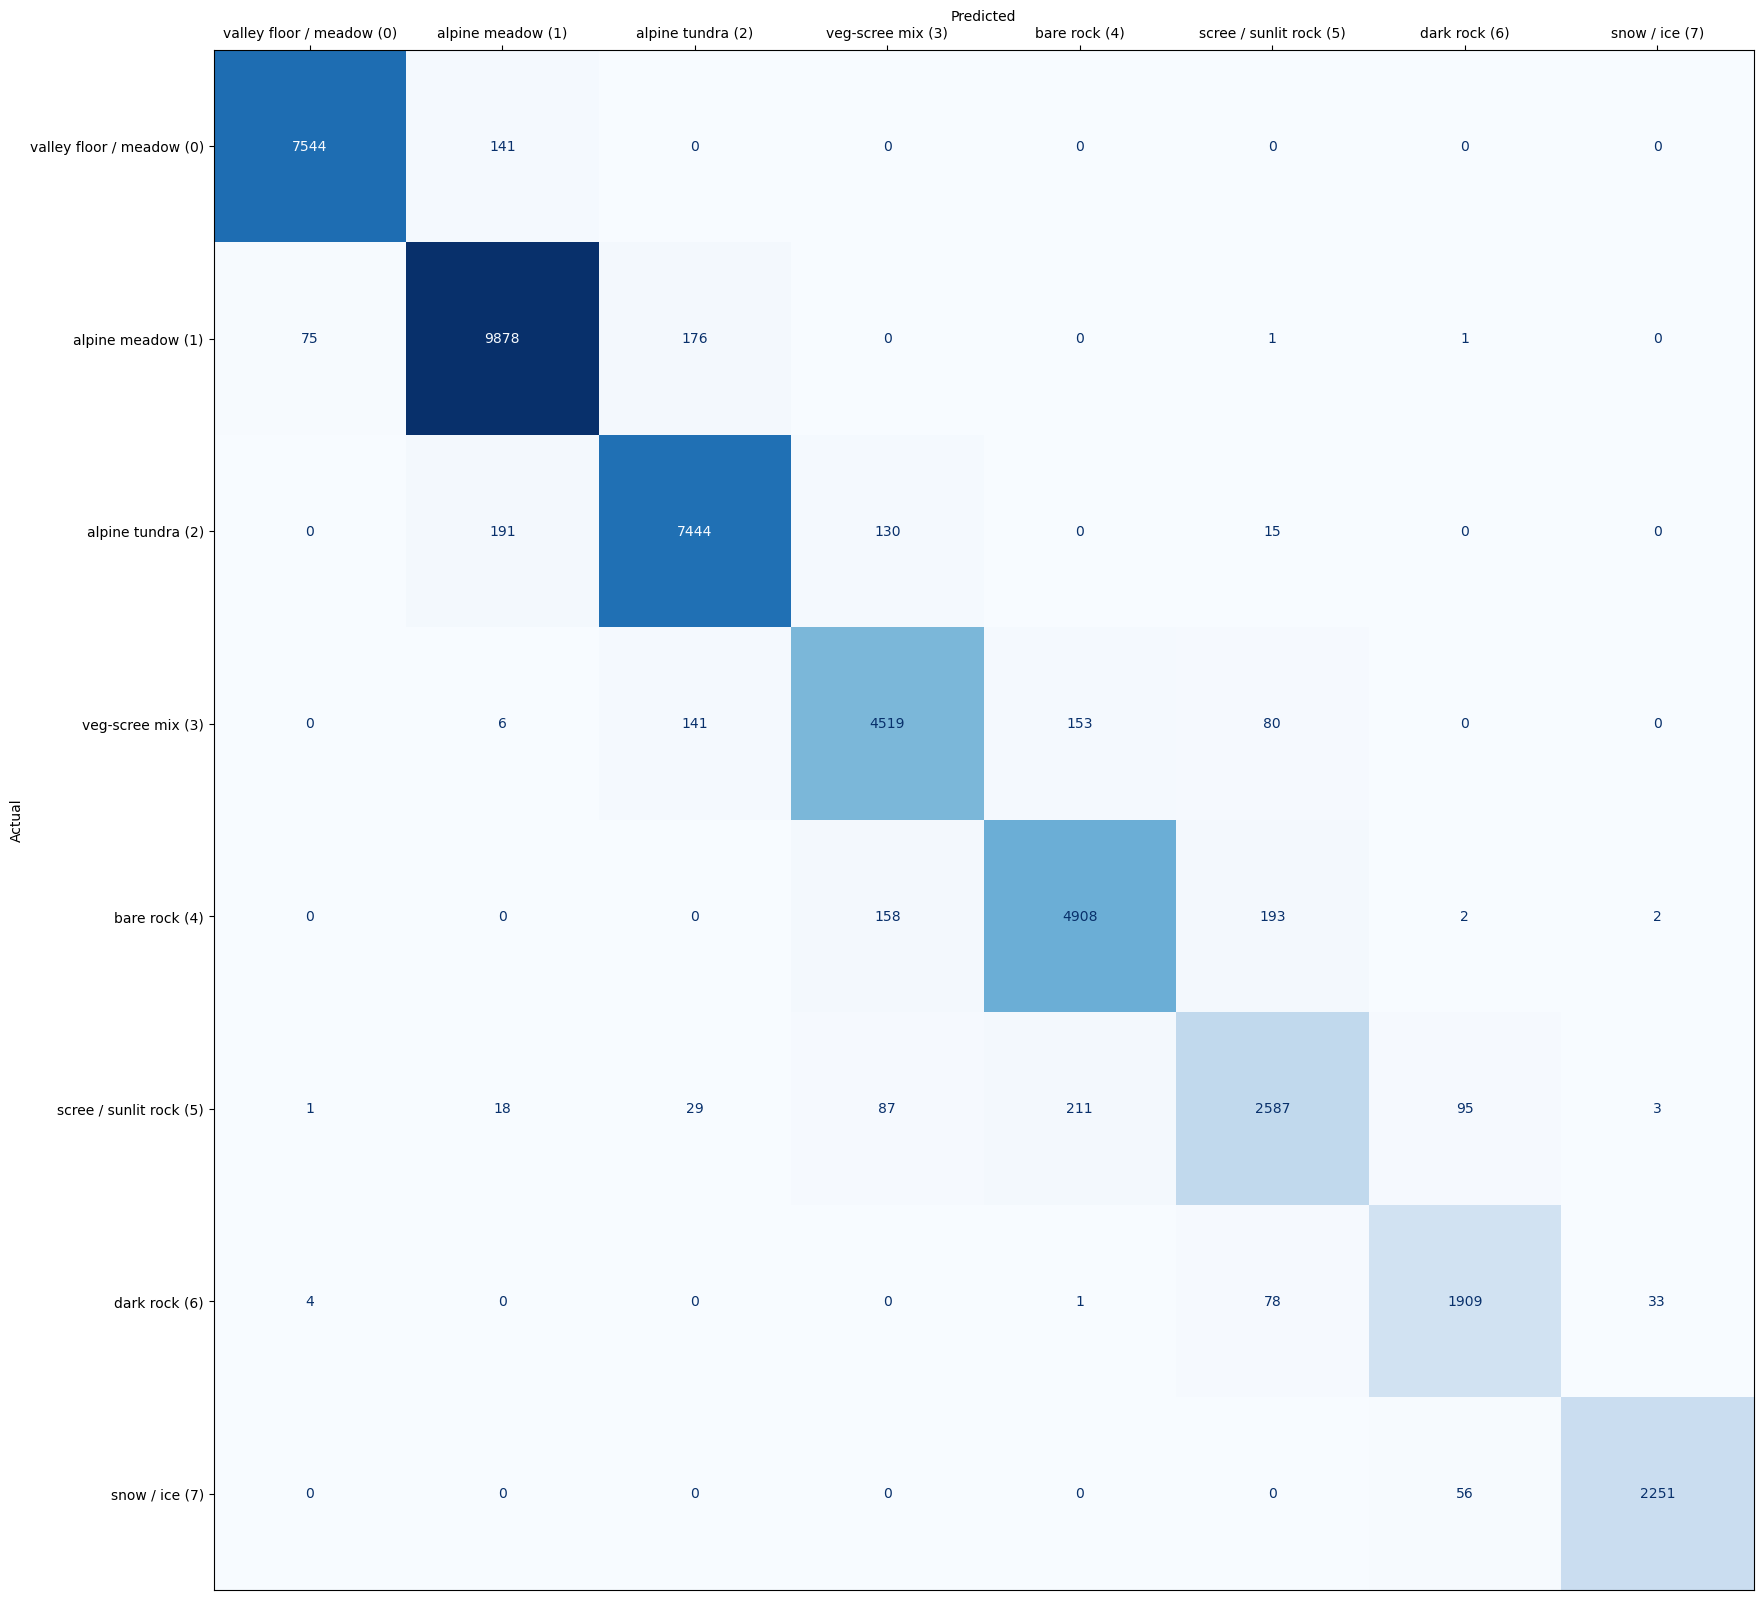

In [14]:
land_type = ["valley floor / meadow (0)", "alpine meadow (1)", "alpine tundra (2)", "veg-scree mix (3)", 
             "bare rock (4)", "scree / sunlit rock (5)", "dark rock (6)", "snow / ice (7)"]

fig, ax = plt.subplots(figsize = (30, 20))

Confusion_Matrix = ConfusionMatrixDisplay.from_predictions(y_true = Y_test_pca["True Test (PCA10)"],
                                                           y_pred = Y_test_pca["Predicted Test (PCA10)"],
                                                           labels = [0,1,2,3,4,5,6,7],
                                                           display_labels = land_type,
                                                           colorbar = False,
                                                           cmap = "Blues",
                                                           ax = ax)

plt.xlabel("Predicted")
plt.ylabel("Actual")
ax = Confusion_Matrix.ax_
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")
plt.show()

In [15]:
Y_true_pca = Y_test_pca["True Test (PCA10)"].values
Y_pred_pca = Y_test_pca["Predicted Test (PCA10)"].values
Y_prob_pca = gbdt.predict_proba(X_test_pca)

balanced_accuracies_pca = []
f1_scores_pca = []
aucs_pca = []

for k in range(8):
    Y_true_k_pca = (Y_true_pca == k).astype(int)
    Y_pred_k_pca = (Y_pred_pca == k).astype(int)
    Y_prob_k_pca = Y_prob_pca[:, k]

    balanced_accuracies_pca.append(balanced_accuracy_score(Y_true_k_pca, Y_pred_k_pca))
    f1_scores_pca.append(f1_score(Y_true_k_pca, Y_pred_k_pca))
    aucs_pca.append(roc_auc_score(Y_true_k_pca, Y_prob_k_pca))

accuracy_pca = accuracy_score(Y_true_pca, Y_pred_pca)
avg_balanced_accuracy_pca = np.mean(balanced_accuracies_pca)
avg_f1_pca = np.mean(f1_scores_pca)
avg_auc_pca = np.mean(aucs_pca)

results_df.loc["GBDT (PCA10)"] = [round(accuracy_pca, 3),
                             round(avg_balanced_accuracy_pca, 3),
                             round(avg_f1_pca, 3),
                             round(avg_auc_pca, 3)]

results_df

,Accuracy,Average Balanced Accuracy,Average F1 Score,Average AUC
GBDT (raw),0.946,0.971,0.952,0.998
GBDT (PCA10),0.952,0.968,0.943,0.998
